In [3]:
import numpy as np

In [4]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [5]:
def softmax_with_temperature(w: np.array, temperature: float) -> float:
    return softmax(-w / temperature)

In [6]:
w = np.array([15, 30, 200000, 500])  # Example weights
T = 0.5  # Temperature
 # Temperature
softmax_with_temperature(w,T)

array([1.00000000e+00, 9.35762297e-14, 0.00000000e+00, 0.00000000e+00])

In [7]:
def power_scaling(weights, alpha):
    scaled = weights ** alpha
    return scaled / scaled.sum()

In [8]:
T = 0.1  # Temperature
def power_scaling_with_temperature(w, T):
    return power_scaling(w, 1 - T)

In [9]:
w = np.array([15, 30, 200000, 500])  # Example weights
T = 0.8
res = power_scaling_with_temperature(w, T)
res

array([0.09217996, 0.10588697, 0.61606179, 0.18587127])

In [10]:
sum(res)

np.float64(1.0)

In [11]:
from pandas import read_csv
import numpy as np

In [12]:
def estimate_diverse_probability(age: int) -> float:
    """
    Returns the estimated probability (as a float between 0 and 1)
    that a person of the given age identifies as 'diverse'.

    This function models gender identity emergence based on age:
    - 0–3 years: assumed not to have established gender identity
    - 4–12 years: early self-identification possible (~1%)
    - 13–17 years: more frequent self-identification (~1.5%)
    - Adults follow survey-based estimations
    """

    if age < 0:
        raise ValueError("Age must be non-negative.")

    if age <= 3:
        return 0.0
    elif age <= 12:
        return 0.01
    elif age <= 17:
        return 0.015
    elif age <= 29:
        return 0.020
    elif age <= 44:
        return 0.010
    elif age <= 64:
        return 0.005
    else:
        return 0.002

In [13]:
# Load the dataset
from pandas import read_csv
path = '../../data/raw/altersaufbau-bevoelkerung-deutschland-zensus-2022.csv'
df = read_csv(path, sep=';', dtype={"age": str, "int": int, "female": int})
df["age"] = df["age"].replace("100+", "100")
df["age"] = df["age"].astype(int)

# Schritt 1: Gesamtbevölkerung pro Alter
df["total"] = df["male"] + df["female"]

# Schritt 2: Geschätzter Anteil divers
df["p_diverse"] = df["age"].apply(estimate_diverse_probability)
df["diverse"] = (df["total"] * df["p_diverse"]).round().astype(int)

# Schritt 3: Verbleibender Anteil (für male/female)
df["residual"] = df["total"] - df["diverse"]

# Verhältnis männlich/weiblich beibehalten (normieren auf 'residual')
total_known = df["male"] + df["female"]
df["male_share"] = df["male"] / total_known
df["female_share"] = df["female"] / total_known

df["male_adjusted"] = (df["residual"] * df["male_share"]).round().astype(int)
df["female_adjusted"] = (df["residual"] * df["female_share"]).round().astype(int)


df


,age,male,female,total,p_diverse,diverse,residual,male_share,female_share,male_adjusted,female_adjusted
0,0,345711,327669,673380,0.000,0,673380,0.513397,0.486603,345711,327669
1,1,359324,341616,700940,0.000,0,700940,0.512632,0.487368,359324,341616
2,2,381737,362425,744162,0.000,0,744162,0.512976,0.487024,381737,362425
3,3,408588,388442,797030,0.000,0,797030,0.512638,0.487362,408588,388442
4,4,401941,381675,783616,0.010,7836,775780,0.512931,0.487069,397922,377858
...,...,...,...,...,...,...,...,...,...,...,...
96,96,10303,32072,42375,0.002,85,42290,0.243139,0.756861,10282,32008
97,97,6491,21961,28452,0.002,57,28395,0.228139,0.771861,6478,21917
98,98,3918,15147,19065,0.002,38,19027,0.205507,0.794493,3910,15117
99,99,2298,10167,12465,0.002,25,12440,0.184356,0.815644,2293,10147


In [14]:
# Save the adjusted DataFrame to a new CSV file
import os
if not os.path.exists('../../data/processed'):
    os.makedirs('../../data/processed')
output_path = '../../data/processed/altersaufbau-bevoelkerung-deutschland-zensus-2022-adjusted.csv'
out_df = df[['age', 'total', 'male_adjusted', 'female_adjusted', 'diverse']]
out_df.to_csv(output_path, sep=';', index=False)

In [15]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

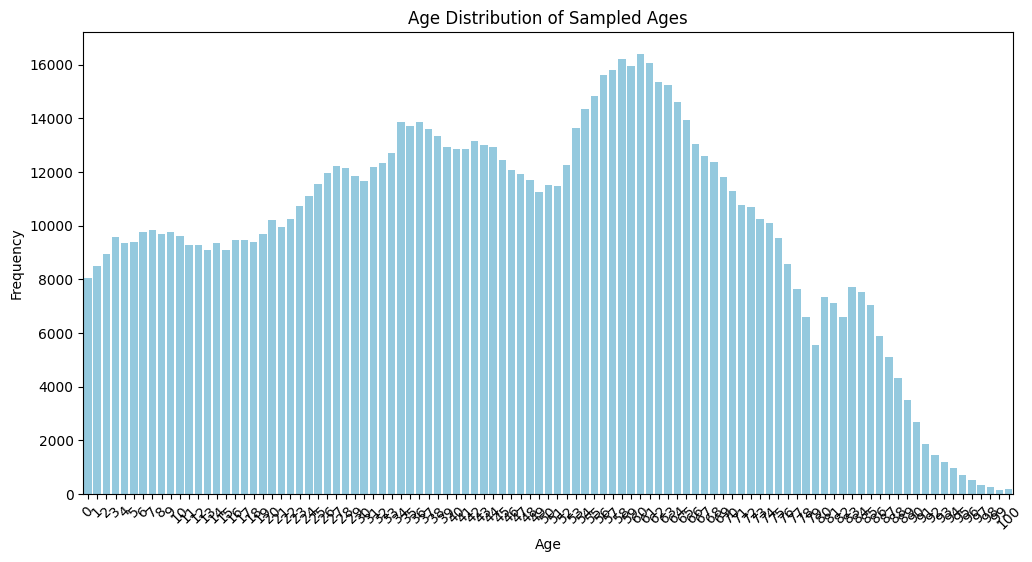

In [16]:
from persona_generator.sampler.age_sampler import AgeSampler

ages = AgeSampler(out_df).sample_n(1000000)
# plot age-distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

age_distribution = pd.Series(ages).value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=age_distribution.index, y=age_distribution.values, color='skyblue')
plt.title("Age Distribution of Sampled Ages")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

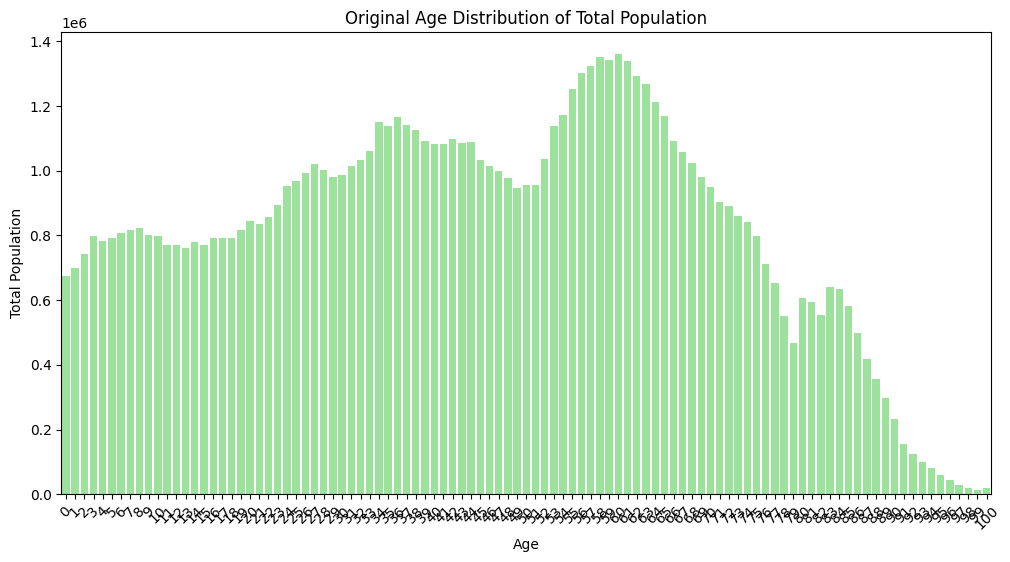

In [17]:
# plot original age distribution of total population
original_age_distribution = df.set_index('age')['total']
plt.figure(figsize=(12, 6))
sns.barplot(x=original_age_distribution.index, y=original_age_distribution.values, color='lightgreen')
plt.title("Original Age Distribution of Total Population")
plt.xlabel("Age")
plt.ylabel("Total Population")
plt.xticks(rotation=45)
plt.show()

In [18]:
from persona_generator.sampler.gender_sampler import GenderSampler

In [19]:
gender_sampler = GenderSampler(out_df, temperature=.7)
genders = gender_sampler.sample_n(np.array(ages))

# Alter als Feld einfügen!
age_gender_pairs = [{"age": i, "male": 0, "female": 0, "diverse": 0} for i in range(101)]

for i in range(len(ages)):
    age = ages[i]
    gender = genders[i]
    age_gender_pairs[age][gender] += 1

# Index kannst du weglassen, columns ist optional:
df_age_gender = pd.DataFrame(age_gender_pairs)
df_age_gender.set_index("age", inplace=True)

df_age_gender

,male,female,diverse
age,,,
0,3978,4071,0
1,4261,4229,0
2,4508,4432,0
3,4797,4782,0
4,4093,4017,1247
...,...,...,...
96,193,296,39
97,121,180,35
98,98,135,17


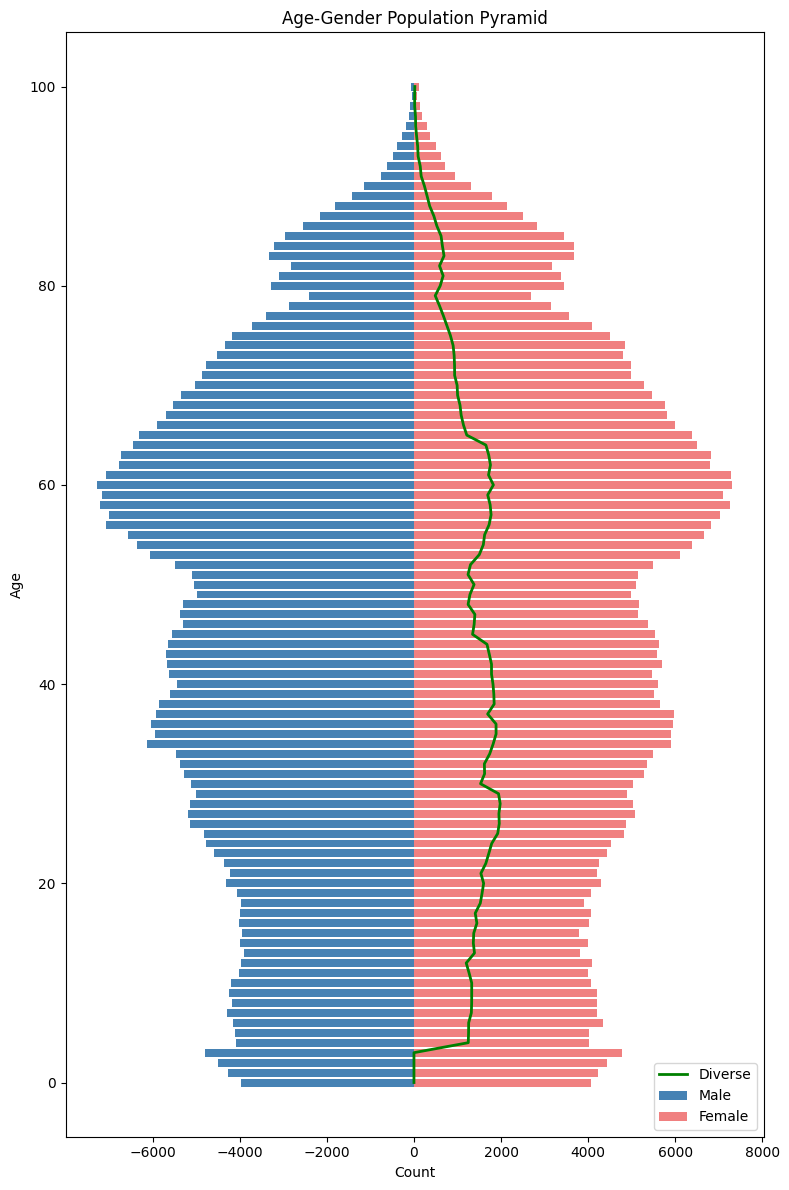

In [20]:
import matplotlib.pyplot as plt

ages = df_age_gender.index           # Alter als Index
male = -df_age_gender["male"]        # Negativ für links
female = df_age_gender["female"]     # Positiv für rechts

plt.figure(figsize=(8, 12))
plt.barh(ages, male, color="steelblue", label="Male")
plt.barh(ages, female, color="lightcoral", label="Female")

plt.xlabel("Count")
plt.ylabel("Age")
plt.title("Age-Gender Population Pyramid")
plt.legend(loc="lower right")

# Optional: Divers
if "diverse" in df_age_gender.columns:
    plt.plot(df_age_gender["diverse"], ages, color="green", label="Diverse", linewidth=2)
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [21]:
out_df.head()

,age,total,male_adjusted,female_adjusted,diverse
0,0,673380,345711,327669,0
1,1,700940,359324,341616,0
2,2,744162,381737,362425,0
3,3,797030,408588,388442,0
4,4,783616,397922,377858,7836


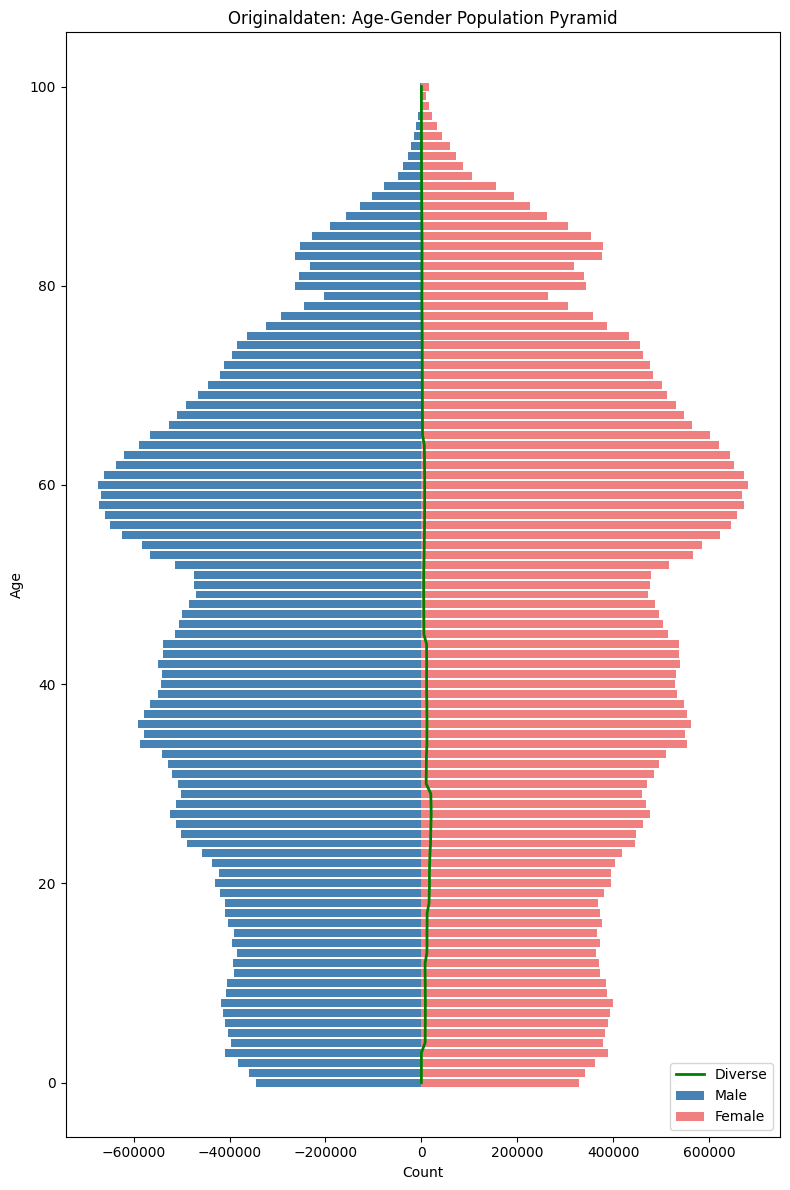

In [22]:
import matplotlib.pyplot as plt

# Daten aus out_df
ages = out_df["age"]
male = -out_df["male_adjusted"]         # Negativ für links
female = out_df["female_adjusted"]      # Positiv für rechts

plt.figure(figsize=(8, 12))
plt.barh(ages, male, color="steelblue", label="Male")
plt.barh(ages, female, color="lightcoral", label="Female")

plt.xlabel("Count")
plt.ylabel("Age")
plt.title("Originaldaten: Age-Gender Population Pyramid")
plt.legend(loc="lower right")

# Optional: Diverse
if "diverse" in out_df.columns:
    plt.plot(out_df["diverse"], ages, color="green", label="Diverse", linewidth=2)
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [23]:
df_fam = pd.read_csv('../../data/raw/familienstand-altersgruppen.csv', sep=';')
df_fam

,Kategorie,ledig,verheiratet/in Lebenspartnerschaft lebend,verwitwet/Lebenspartner verstorben,geschieden/Lebenspartnerschaft aufgehoben
0,unter 20,100,0,0,0
1,20–25,97,3,0,"0,1"
2,25–30,"83,6","15,7",0,"0,7"
3,30–35,"59,2","38,5","0,1","2,3"
4,35–40,"42,6","52,3","0,2","4,9"
5,40–45,"33,4","58,2","0,4",8
6,45–50,"26,9","61,1","0,8","11,2"
7,50–55,"21,8","62,9","1,6","13,7"
8,55–60,"17,8","63,8","2,8","15,6"
9,60–65,"13,5","65,4","5,3","15,8"


In [24]:
import re

# Neue Tabelle vorbereiten
rows = []
for idx, row in df_fam.iterrows():
    group_str = row["Kategorie"]
    # Altersgruppe extrahieren
    m = re.match(r"(\d+)[–-](\d+)", group_str)
    if m:
        start, end = int(m.group(1)), int(m.group(2))
    elif "unter" in group_str:
        m = re.search(r"(\d+)", group_str)
        start = 0
        end = int(m.group(1)) - 1 if m else 19
    elif "älter" in group_str or "und älter" in group_str:
        m = re.match(r"(\d+)", group_str)
        start = int(m.group(1)) if m else 80
        end = 100   # Setze Obergrenze, ggf. anpassen
    else:
        m = re.match(r"(\d+)", group_str)
        start = end = int(m.group(1)) if m else (None, None)
    # Werte umwandeln
    ledig = float(str(row['ledig']).replace(",", "."))
    verheiratet = float(str(row['verheiratet/in Lebenspartnerschaft lebend']).replace(",", "."))
    verwitwet = float(str(row['verwitwet/Lebenspartner verstorben']).replace(",", "."))
    geschieden = float(str(row['geschieden/Lebenspartnerschaft aufgehoben']).replace(",", "."))
    # Hinzufügen
    rows.append({
        "from": start,
        "to": end,
        "single": ledig,
        "married": verheiratet,
        "widowed": verwitwet,
        "divorced": geschieden
    })

df_intervals = pd.DataFrame(rows)
df_intervals.to_csv('../../data/processed/familienstand-altersgruppen.csv', sep=';', index=False)


In [25]:
from persona_generator.sampler.marriage_status_sampler import MarriageStatusSampler

ms_sampler = MarriageStatusSampler(df_intervals)

In [26]:
marriage_status_samples = ms_sampler.sample_n(ages)
marriage_status_samples

[np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('married'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('single'),
 np.str_('married'),
 np.str_('single'),
 np.str_('single'),
 np.str_('married'),
 np.str_('single'),
 np.str_('married'),
 np.str_('married'),
 np.str_('single'),
 np.str_('married'),
 np.str_('married'),
 np.str_('married'),
 np.str_('single'),
 np.str_('single'),
 np.str_('divorced'),
 np.str_('married'),
 np.str_('single'),
 np.str_('divorced'),
 np.str_('single'),
 np.str_('married'),
 np.st

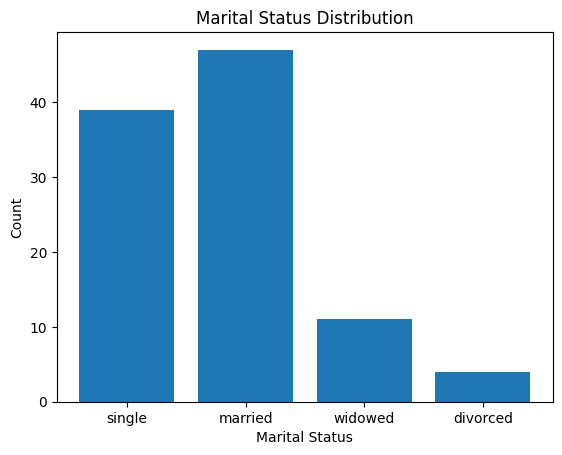

In [27]:
res = {
    "single": 0,
    "married": 0,
    "widowed": 0,
    "divorced": 0
}
for sample in marriage_status_samples:
    res[sample] += 1

# show bar chart
import matplotlib.pyplot as plt
labels = list(res.keys())
values = list(res.values())
plt.bar(labels, values)
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution")
plt.show()

In [39]:
df_migration = pd.read_csv('../../data/raw/12211-0200_de_flat.csv', sep=';')
relevant_df_migration = df_migration[['2_variable_attribute_label', '3_variable_attribute_label', '4_variable_attribute_label', 'value']]

In [40]:
relevant_df_migration.columns

Index(['2_variable_attribute_label', '3_variable_attribute_label',
       '4_variable_attribute_label', 'value'],
      dtype='object')

In [51]:
relevant_df_migration

,2_variable_attribute_label,3_variable_attribute_label,4_variable_attribute_label,value
0,Ausländer ohne eigene Migrationserfahrung,weiblich,65 Jahre und mehr,14
1,Insgesamt,weiblich,55 bis unter 65 Jahre,6553
2,Ausländer ohne eigene Migrationserfahrung,männlich,15 bis unter 25 Jahre,73
3,Spätaussiedler,Insgesamt,15 bis unter 25 Jahre,42
4,Mit Migrationshintergrund,weiblich,45 bis unter 55 Jahre,1772
...,...,...,...,...
187,Deutsche ohne eigene Migrationserfahrung,männlich,unter 15 Jahre,1580
188,Ohne Migrationshintergrund,männlich,35 bis unter 45 Jahre,3463
189,Spätaussiedler,männlich,15 bis unter 25 Jahre,21
190,Insgesamt,weiblich,25 bis unter 35 Jahre,4949


In [54]:
relevant_df_migration['4_variable_attribute_label'].unique()

array(['65 Jahre und mehr', '55 bis unter 65 Jahre',
       '15 bis unter 25 Jahre', '45 bis unter 55 Jahre', 'Insgesamt',
       'unter 15 Jahre', '25 bis unter 35 Jahre', '35 bis unter 45 Jahre'],
      dtype=object)

In [19]:
WITH_MIGRATION = [
    'Mit Migrationshintergrund',
    'Spätaussiedler',
    'Ausländer mit eigener Migrationserfahrung',
    'Ausländer ohne eigene Migrationserfahrung',
    'Deutsche mit eigener Migrationserfahrung'
]
WITHOUT_MIGRATION = [
    'Ohne Migrationshintergrund',
    'Deutsche ohne eigene Migrationserfahrung'
]

In [21]:
import re

def parse_age_range(age_str):
    if pd.isnull(age_str):
        return None, None

    # "15 bis unter 25 Jahre"
    match = re.match(r'(\d+)\s+bis unter\s+(\d+)\s+Jahre', age_str)
    if match:
        return int(match.group(1)), int(match.group(2))-1  # -1, da "unter" nicht inkludiert ist

    # "unter 15 Jahre"
    match = re.match(r'unter\s+(\d+)\s+Jahre', age_str)
    if match:
        return 0, int(match.group(1))-1  # -1, da "unter" nicht inkludiert ist

    # "65 Jahre und mehr" → setze age_to = 100
    match = re.match(r'(\d+)\s+Jahre und mehr', age_str)
    if match:
        return int(match.group(1)), 100

    return None, None

In [ ]:
def classify_migration_status(label):
    if label in WITH_MIGRATION:
        return 'with_migration'
    elif label in WITHOUT_MIGRATION:
        return 'without_migration'
    else:
        return None  # falls z.B. "Insgesamt" oder irrelevante Gruppen

    
# Kopie erzeugen, um das Original nicht zu verändern
df = relevant_df_migration.copy()

# Spaltennamen vereinfachen
df.columns = ['migration_status', 'gender', 'age_range', 'value']

df['migration_category'] = df['migration_status'].apply(classify_migration_status)
df = df[df['migration_category'].notnull()]  # Filtere alle nicht zuordbaren Gruppen

df = df[df['age_range'] != 'Insgesamt'] # Entferne die Zeile mit "Insgesamt"

# Altersbereich extrahieren
df[['age_from', 'age_to']] = df['age_range'].apply(lambda x: pd.Series(parse_age_range(x)))
df['value'] = df['value'] * 1000

# Pivotieren
pivot_df = df.pivot_table(
    index=['age_from', 'age_to', 'gender'],
    columns='migration_category',
    values='value',
    aggfunc='sum'
).reset_index()

# Ergebnis anzeigen
pivot_df


NameError: name 'relevant_df_migration' is not defined

In [57]:
pivot_df.to_csv('../../data/processed/migration_population_distribution.csv', sep=';', index=False)

In [5]:
import pandas as pd
df_edu = pd.read_csv('../../data/raw/Bildung_Bevölkerung_1211-0100_de.csv')
df_edu

,Unnamed: 0,Jahr,Geschlecht,Altersgruppe,Schulabschluss,Anzahl
0,0,2024,männlich,15 bis unter 25 Jahre,Noch in schulischer Ausbildung,1276
1,1,2024,männlich,25 bis unter 35 Jahre,Noch in schulischer Ausbildung,10
2,7,2024,männlich,Insgesamt,Noch in schulischer Ausbildung,1291
3,8,2024,weiblich,15 bis unter 25 Jahre,Noch in schulischer Ausbildung,1223
4,9,2024,weiblich,25 bis unter 35 Jahre,Noch in schulischer Ausbildung,9
...,...,...,...,...,...,...
139,187,2024,Insgesamt,45 bis unter 55 Jahre,Insgesamt,10355
140,188,2024,Insgesamt,55 bis unter 65 Jahre,Insgesamt,13018
141,189,2024,Insgesamt,65 bis unter 75 Jahre,Insgesamt,9567
142,190,2024,Insgesamt,75 Jahre und mehr,Insgesamt,8558


In [7]:
df_edu['Schulabschluss'].unique()

array(['Noch in schulischer Ausbildung', 'Haupt- (Volks-)schulabschluss',
       'Abschluss der polytechnischen Oberschule',
       'Realschule oder gleichwertiger Abschluss',
       'Fachhochschul- oder Hochschulreife',
       'Ohne allgemeinen Schulabschluss', 'Insgesamt'], dtype=object)

In [8]:
df_edu['Altersgruppe'].unique()

array(['15 bis unter 25 Jahre', '25 bis unter 35 Jahre', 'Insgesamt',
       '35 bis unter 45 Jahre', '45 bis unter 55 Jahre',
       '55 bis unter 65 Jahre', '65 bis unter 75 Jahre',
       '75 Jahre und mehr'], dtype=object)

In [22]:
import re

def parse_age_range(age_str):
    if pd.isnull(age_str):
        return None, None

    # "15 bis unter 25 Jahre"
    match = re.match(r'(\d+)\s+bis unter\s+(\d+)\s+Jahre', age_str)
    if match:
        return int(match.group(1)), int(match.group(2))-1  # -1, da "unter" nicht inkludiert ist

    # "unter 15 Jahre"
    match = re.match(r'unter\s+(\d+)\s+Jahre', age_str)
    if match:
        return 0, int(match.group(1))-1  # -1, da "unter" nicht inkludiert ist

    # "65 Jahre und mehr" → setze age_to = 100
    match = re.match(r'(\d+)\s+Jahre und mehr', age_str)
    if match:
        return int(match.group(1)), 100

    return None, None

In [ ]:
df_edu = pd.read_csv('../../data/raw/Bildung_Bevölkerung_1211-0100_de.csv')
df_edu = df_edu[df_edu['Altersgruppe'] != 'Insgesamt']
df_edu = df_edu[df_edu['Schulabschluss'] != 'Insgesamt']
df_edu = df_edu.drop(columns=["Unnamed: 0"])
df_edu = df_edu.drop(columns=["Jahr"])
df_edu[['age_from', 'age_to']] = df_edu['Altersgruppe'].apply(lambda x: pd.Series(parse_age_range(x)))
df_edu = df_edu.drop(columns=["Altersgruppe"])
df_edu

,Geschlecht,Altersgruppe,Schulabschluss,Anzahl
0,männlich,15 bis unter 25 Jahre,Noch in schulischer Ausbildung,1276
1,männlich,25 bis unter 35 Jahre,Noch in schulischer Ausbildung,10
3,weiblich,15 bis unter 25 Jahre,Noch in schulischer Ausbildung,1223
4,weiblich,25 bis unter 35 Jahre,Noch in schulischer Ausbildung,9
6,Insgesamt,15 bis unter 25 Jahre,Noch in schulischer Ausbildung,2499
...,...,...,...,...
114,Insgesamt,35 bis unter 45 Jahre,Ohne allgemeinen Schulabschluss,753
115,Insgesamt,45 bis unter 55 Jahre,Ohne allgemeinen Schulabschluss,694
116,Insgesamt,55 bis unter 65 Jahre,Ohne allgemeinen Schulabschluss,666
117,Insgesamt,65 bis unter 75 Jahre,Ohne allgemeinen Schulabschluss,440


In [ ]:
df_edu['Jahr']

array([2024])

In [17]:
df_edu.to_csv('../../data/processed/education_population_distribution_2024.csv', sep=';', index=False)